In [1]:
import Models.SIRD as sird
import Models.SIRD_Time as sird_time
import Models.SIRD_Beta_Time as sird_beta

import Models.SAIRD as saird
import Models.SAIRD_Time as saird_time

import Models.SAIRD_Feedback as saird_fb

import Models.SIRD_Feedback as sird_fb

import Models.SIRD_Feedback_Delay as sird_fd

import Models.SIRD_Feedback_Delay

import Models.process as process

import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

In [2]:
#pathc = "../Data/Italian Data/"
pathc="../Data/Covid Tracking State Data/"
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
#filename = "National Data.csv"
filename = "CA.csv"
dates, infectRaw, recovRaw, deadRaw = process.loadData(pathc + filename)

recovRaw = process.getRecov(infectRaw, deadRaw)
infectRaw = process.getCurrentInfect(infectRaw, recovRaw, deadRaw)

pop = 40000000

skipDays = 25
numDays = 250 #len(infectRaw) - 28 #just to get initial beginning data
#asympt = asymptRaw[skipDays:numDays]
infect = infectRaw[skipDays:numDays]
recov = recovRaw[skipDays:numDays] 
dead = deadRaw[skipDays:numDays]

daysToPredict = 130

## SIRD and SIRD time varying model

In [3]:
sird.weightDecay = .99
sird.regularizer = 10

In [4]:
q = sird.getQ(infect,recov, dead, pop)
print("q =", q)

#q=.011
suscept = process.getSuscept(infect,recov,dead, q,pop)

q = 0.258708958


[0.07812456879602717, 0.07499401690063308, 0.0012144519961221748]


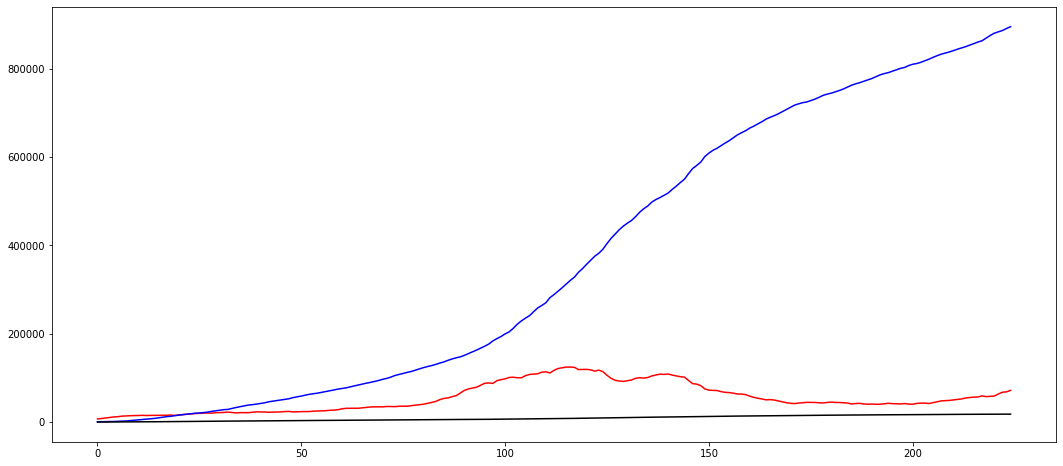

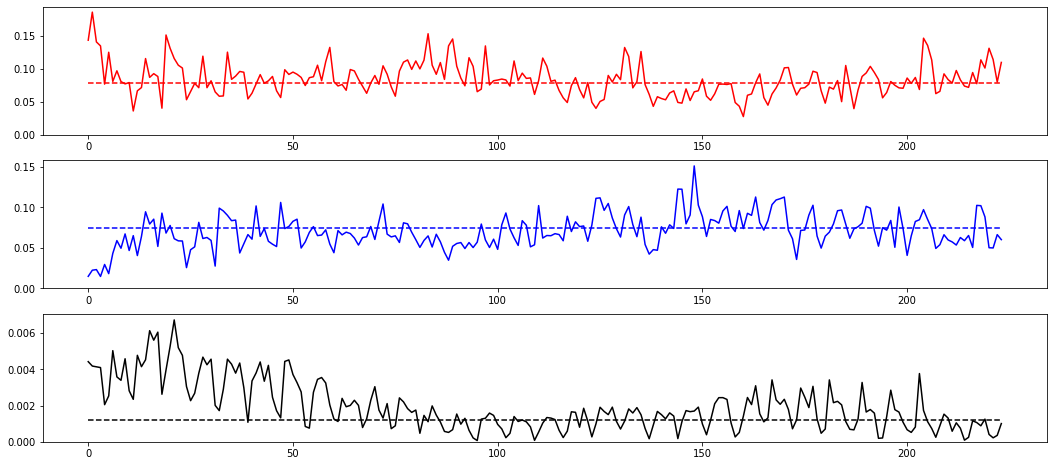

In [5]:
fig,ax = sird.displayData(suscept, infect, recov, dead, graphVals=[0,1,1,1])

linVars = sird.getLinVars(suscept, infect, recov, dead)
print(linVars)

linVarsTime, fig, ax = sird_time.getLinVars(suscept, infect, recov, dead, graph=True)

ax[0].plot(np.ones(len(linVarsTime[:,0]))*linVars[0], color="red", linestyle="dashed")
ax[1].plot(np.ones(len(linVarsTime[:,1]))*linVars[1], color="blue", linestyle="dashed")
ax[2].plot(np.ones(len(linVarsTime[:,2]))*linVars[2], color="black", linestyle="dashed")

Lin Vars: [0.10240737 0.05409148 0.00090211]
Lin Vars: [0.09857856255794271, 0.05949956652420425, 0.001603152559518818]


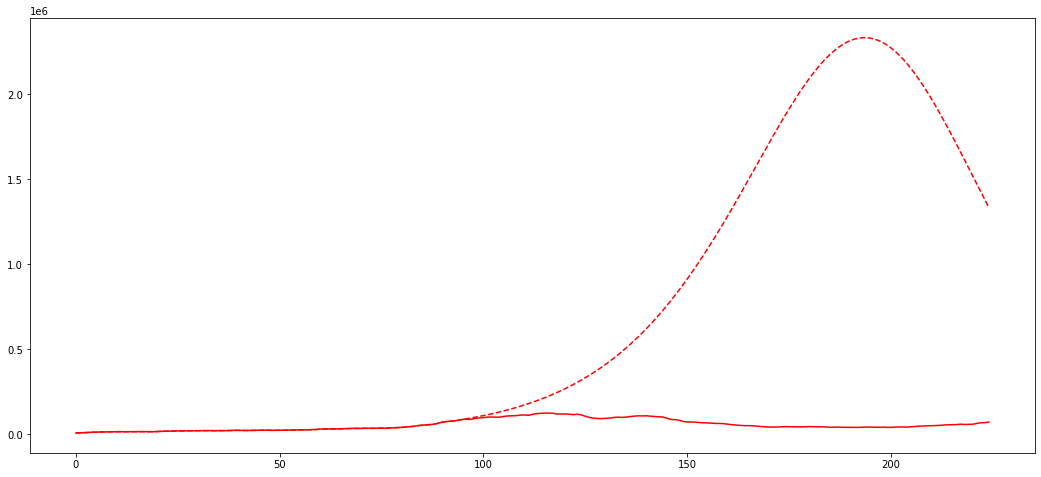

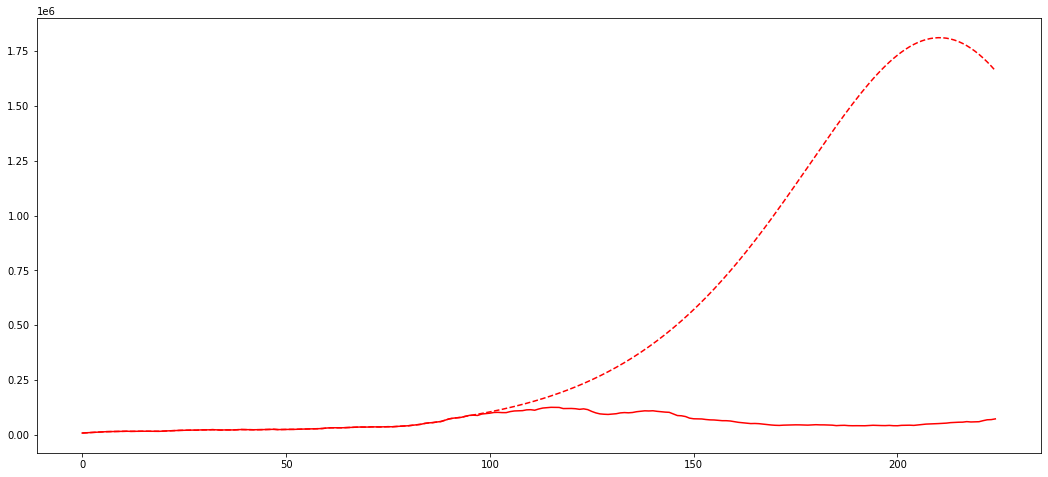

In [6]:
#daysToPredict = 90
sird_time.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);
sird.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);

## SAIRD Feedback
Instead of using SI/S+I, we are using SA/S+A (so the assumption is that asyptomatic are the ones responsible for the spread). This essentially makes the SAIRD Feedback very close to the SIRD Feedback delay

In [7]:
saird_fb.weightDecay = .99
saird_fb.regularizer = 10
saird_fb.betaUseDecay = True #no weight decay when solving beta vars

In [8]:
shiftDays = 21
asymptRaw = saird.getAsympt(infectRaw, recovRaw, deadRaw, shift=shiftDays)
asympt = asymptRaw[skipDays:numDays]

In [9]:
q = saird.getQ(infect, asympt, recov, dead, pop) #use non feedback model to get q value, should be accurate enough
print("q =", q)

#q=.24
suscept = saird.getSuscept(infect,asympt,recov,dead, q,pop)

q = 0.26230922999999995


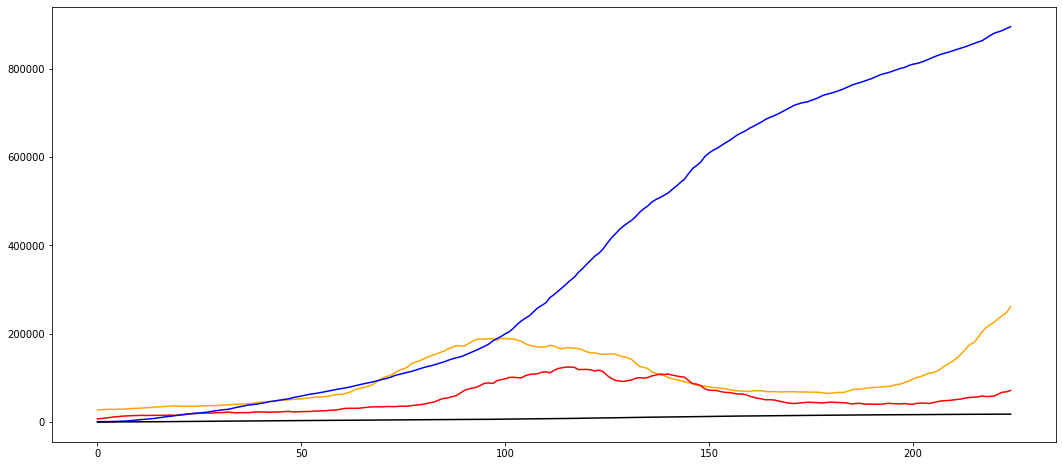

In [10]:
fig,ax = saird_fb.displayData(suscept, asympt, infect, recov, dead, graphVals=[0,1,1,1,1])

In [11]:
b1Range = (0, 5000)
b2Range = (1, 5)

betaVarsResol = [100, 5]

linVars, nonLinVars = saird_fb.solveAllVars(suscept,asympt,infect,recov,dead, [b1Range, b2Range], betaVarsResol, printOut=True)

Solution: 
b0:  0.00637984385704496
b1:  0.05364410834851384
k:   0.054917929066000716
g:   0.07499401690063308
nu:  0.0012144519961221748
b2:  1050.0
b3:  4.6
cost:  13307741.017786272



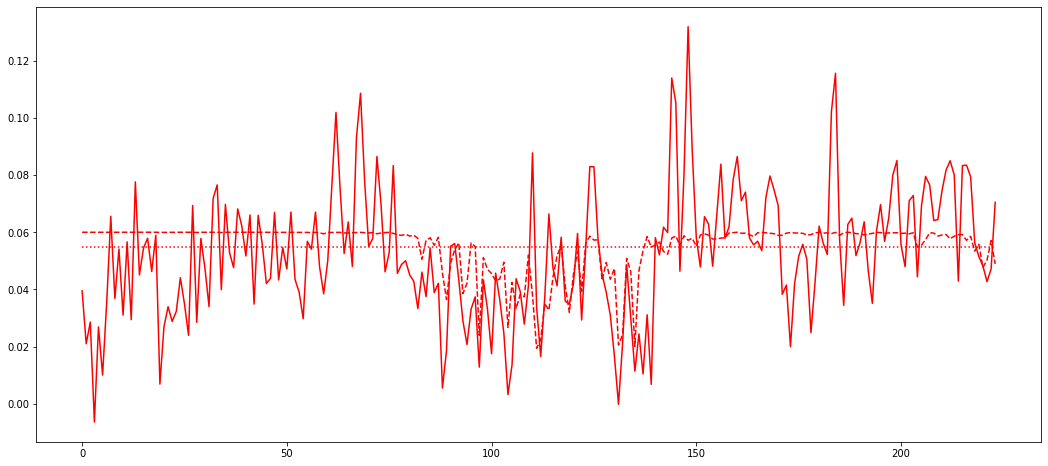

In [12]:
betaTime = saird_fb.getBetaTime(suscept, asympt, infect, recov, dead, linVars, nonLinVars)
linVarsTime = saird_time.getLinVars(suscept, asympt, infect, recov, dead)
linVarsConst = saird.getLinVars(suscept, asympt, infect, recov, dead)


fig, ax = plt.subplots(figsize=(18,8))
ax.plot(np.ones(len(linVarsTime[:,0]))*linVarsConst[0], color="red", linestyle="dotted") #constant beta
ax.plot(betaTime, color="red", linestyle="dashed") #feedback beta
ax.plot(linVarsTime[:,0], color="red") #time varying beta

Lin Vars: [0.06152063960581698, 0.04747495480697526, 0.060425013112735564, 0.001792915325306099]
Non Lin Vars: [1050.0, 4.6]
Lin Vars: [0.00637984385704496, 0.05364410834851384, 0.054917929066000716, 0.07499401690063308, 0.0012144519961221748]


C:\Users\Daniel\COVID-Tracking-Biola-Summer\Code\Models\SAIRD_Feedback.py:341: RuntimeWarning: invalid value encountered in double_scalars
  xPredict[t,0,1] = -(SP[t] * AP[t]) / (SP[t] + AP[t]) * (1 / (1 + (nonLinParams[0]*newI/pop)**nonLinParams[1] )) #b1
C:\Users\Daniel\COVID-Tracking-Biola-Summer\Code\Models\SAIRD_Feedback.py:345: RuntimeWarning: invalid value encountered in double_scalars
  xPredict[t,1,1] = (SP[t] * AP[t]) / (SP[t] + AP[t]) * (1 / (1 + (nonLinParams[0]*newI/pop)**nonLinParams[1] )) #b1


Non Lin Vars: [250.0, 3.0]
Lin Vars: [-1.8248566314502281, 1.881883568515167, 0.04657679298111717, 0.05949956652420425, 0.001603152559518818]


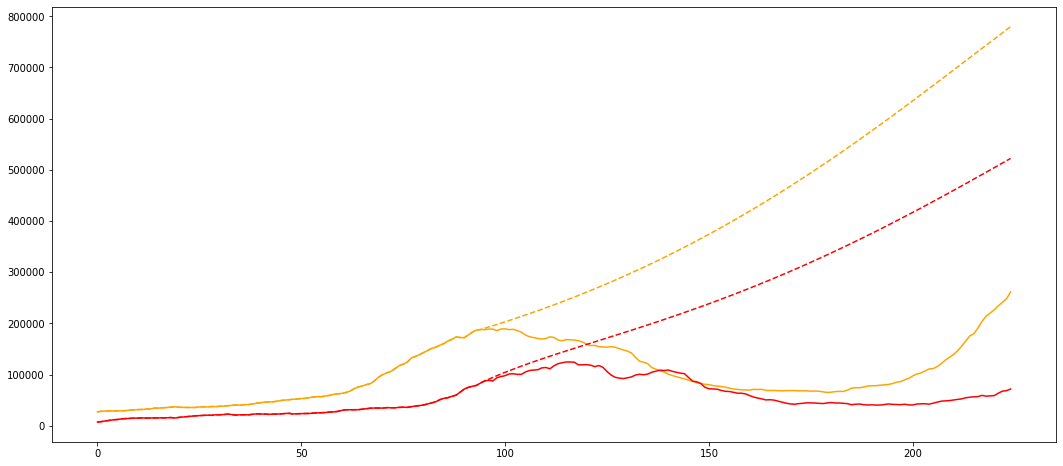

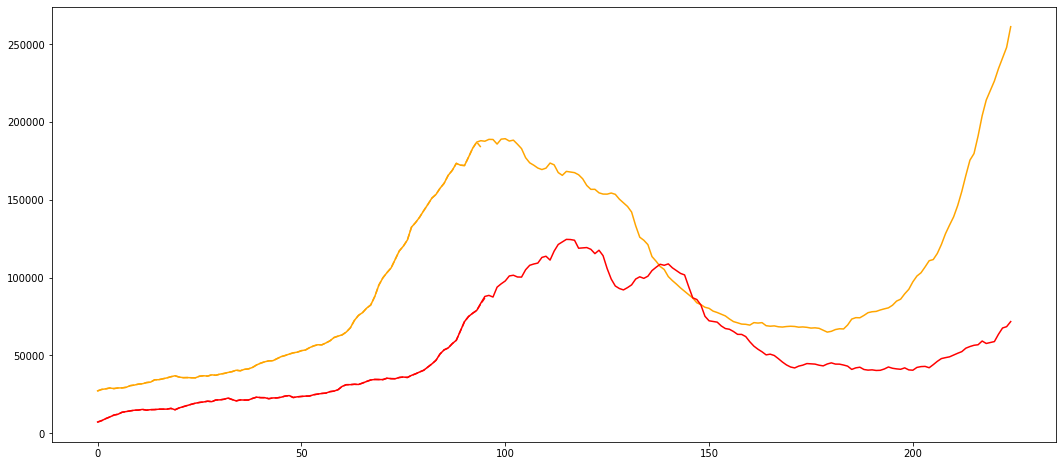

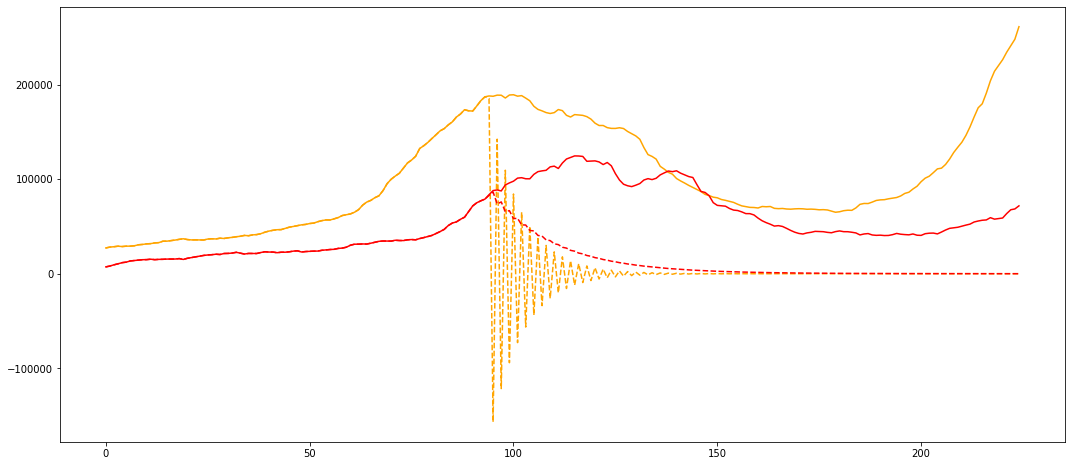

In [13]:
#daysToPredict = 180
saird.predictMatch(suscept, asympt, infect, recov, dead, daysToPredict, graphVals=[0,1,1,0,0]);

#note using the nonLinVars is trained on the whole data includinig the predicted days
saird_fb.predictMatch(suscept,asympt,infect,recov,dead, daysToPredict, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,1,0,0]);

#only train nonLinVars on the non predicted days only
saird_fb.predictMatch(suscept, asympt, infect, recov, dead, daysToPredict, graphVals=[0,1,1,0,0]);

Non Lin Vars: [1050.0, 4.6]
Lin Vars: [0.00637984385704496, 0.05364410834851384, 0.054917929066000716, 0.07499401690063308, 0.0012144519961221748]


C:\Users\Daniel\COVID-Tracking-Biola-Summer\Code\Models\SAIRD_Feedback.py:341: RuntimeWarning: invalid value encountered in double_scalars
  xPredict[t,0,1] = -(SP[t] * AP[t]) / (SP[t] + AP[t]) * (1 / (1 + (nonLinParams[0]*newI/pop)**nonLinParams[1] )) #b1
C:\Users\Daniel\COVID-Tracking-Biola-Summer\Code\Models\SAIRD_Feedback.py:345: RuntimeWarning: invalid value encountered in double_scalars
  xPredict[t,1,1] = (SP[t] * AP[t]) / (SP[t] + AP[t]) * (1 / (1 + (nonLinParams[0]*newI/pop)**nonLinParams[1] )) #b1


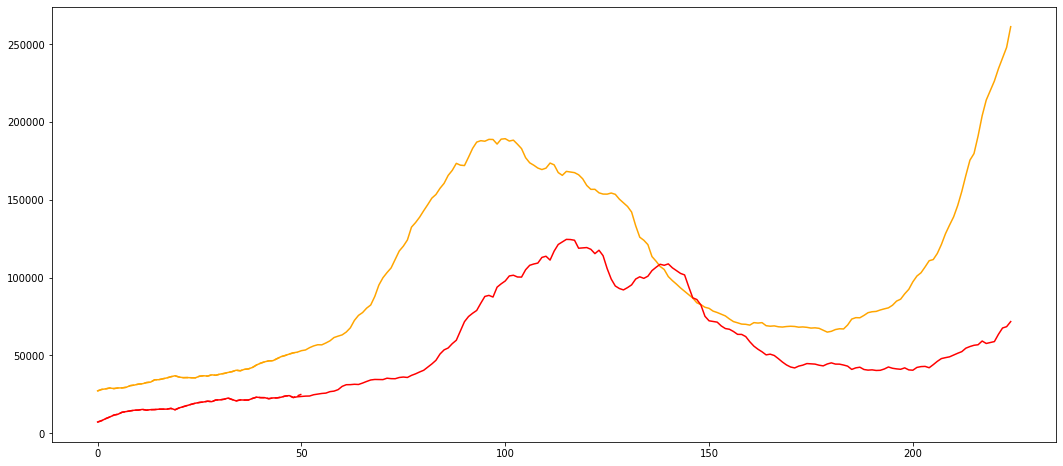

In [14]:
dtp = len(suscept) - 50

saird_fb.predictMatch(suscept,asympt,infect,recov,dead, dtp, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,1,0,0]);

## SIRD Feedback (no delay)

In [15]:
sird_fb.weightDecay = .99
sird_fb.regularizer = 10
sird_fb.betaUseDecay = False #no weight decay when solving beta vars

In [16]:
q = sird.getQ(infect,recov, dead, pop) #use non feedback model to get q value, should be accurate enough
print("q =", q)

#q=.011
suscept = process.getSuscept(infect,recov,dead, q,pop)

q = 0.258708958


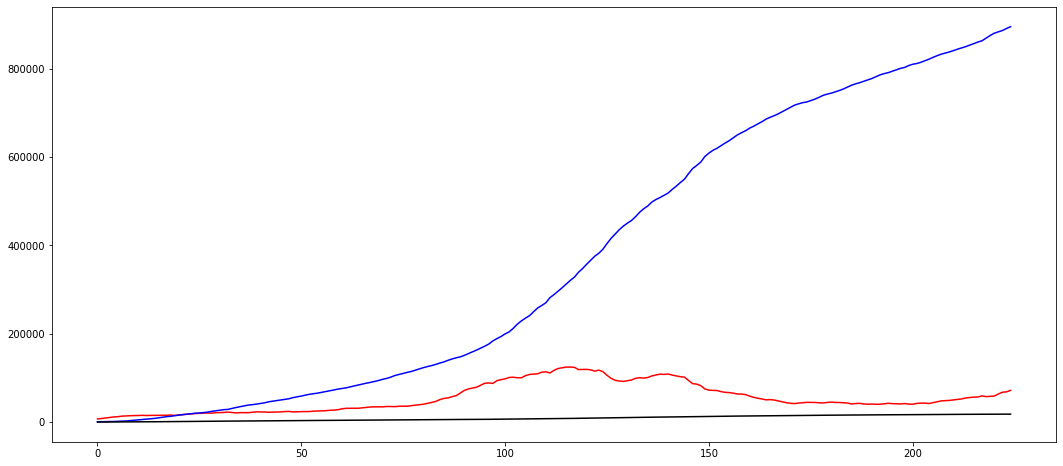

In [17]:
fig,ax = sird_fb.displayData(suscept, infect, recov, dead, graphVals=[0,1,1,1])

In [18]:
b1Range = (0, 5000)
b2Range = (1, 5)

betaVarsResol = [100, 5]

linVars, nonLinVars = sird_fb.solveAllVars(suscept, infect, recov, dead, [b1Range, b2Range], betaVarsResol, printOut=True)

Solution: 
b0:  0.2578498662815159
b1:  -0.19563496564824862
g:   0.07499401690063308
nu:  0.0012144519961221748
b2:  600.0
b3:  2.8
cost:  2764360.4636857905



In [19]:
sirdLinVars = sird.getLinVars(suscept, infect, recov, dead)
print("cost: ", sird.getError(suscept, infect, recov, dead, sirdLinVars))

cost:  3374367.5194743797


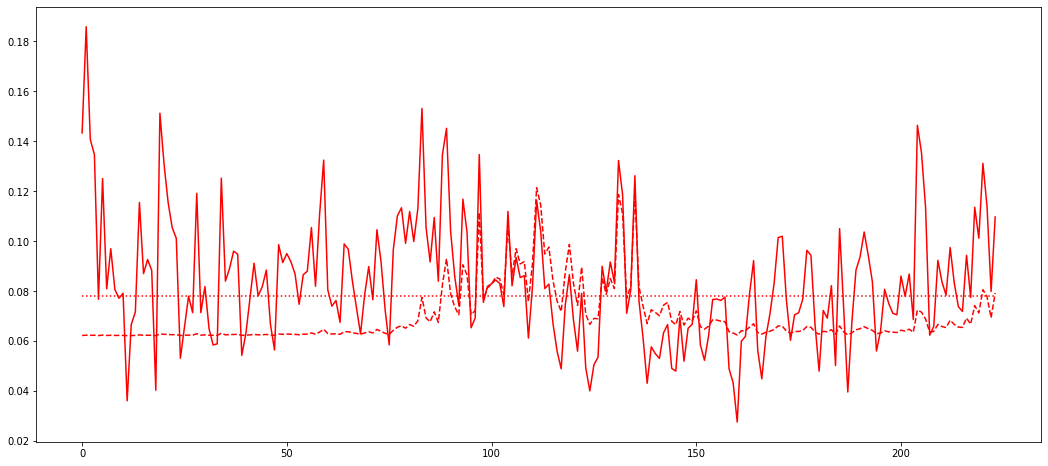

In [20]:
betaTime = sird_fb.getBetaTime(suscept, infect, recov, dead, linVars, nonLinVars)
linVarsTime = sird_time.getLinVars(suscept, infect, recov, dead)
linVarsConst = sird.getLinVars(suscept, infect, recov, dead)


fig, ax = plt.subplots(figsize=(18,8))
ax.plot(np.ones(len(linVarsTime[:,0]))*linVarsConst[0], color="red", linestyle="dotted") #constant beta
ax.plot(betaTime, color="red", linestyle="dashed") #feedback beta
ax.plot(linVarsTime[:,0], color="red") #time varying beta

Lin Vars: [0.09857856255794271, 0.05949956652420425, 0.001603152559518818]
Non Lin Vars: [550.0, 2.0]
Lin Vars: [0.37957406066107513, -0.3038901096123123, 0.05949956652420425, 0.001603152559518818]


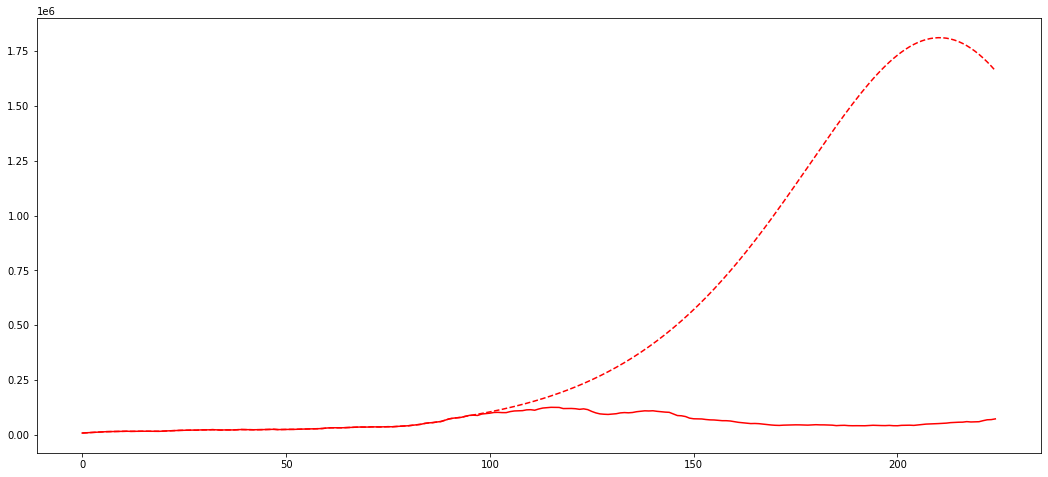

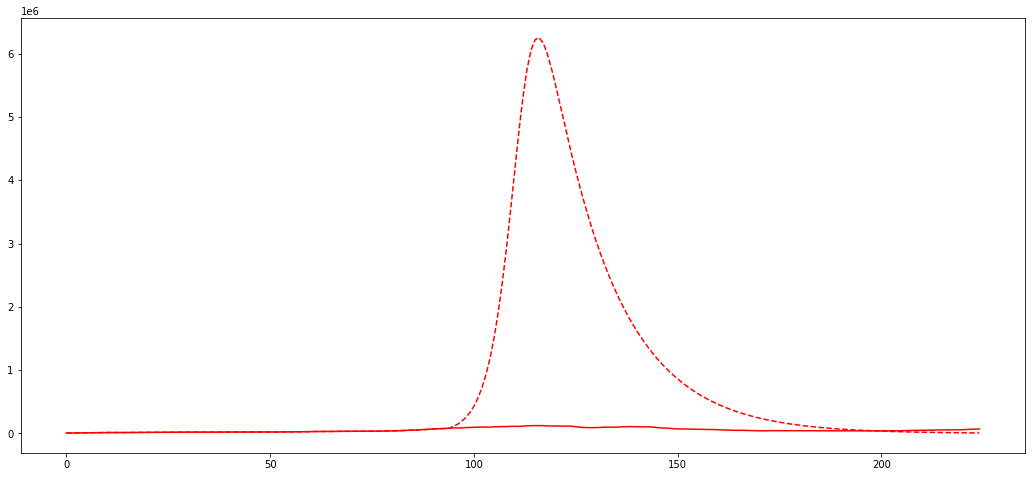

In [21]:
#daysToPredict = 100
sird.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);
sird_fb.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);

## SIRD Feedback with delay

In [22]:
sird_fd.weightDecay = .99 #very small amount of decay
sird_fd.regularizer = 10
sird_fd.betaUseDecay = True

sird_fd.delay = 21

In [23]:
q = sird.getQ(infect,recov, dead, pop) #use non feedback model to get q value, should be accurate enough
print("q =", q)

#q=.011
suscept = process.getSuscept(infect,recov,dead, q,pop)

q = 0.258708958


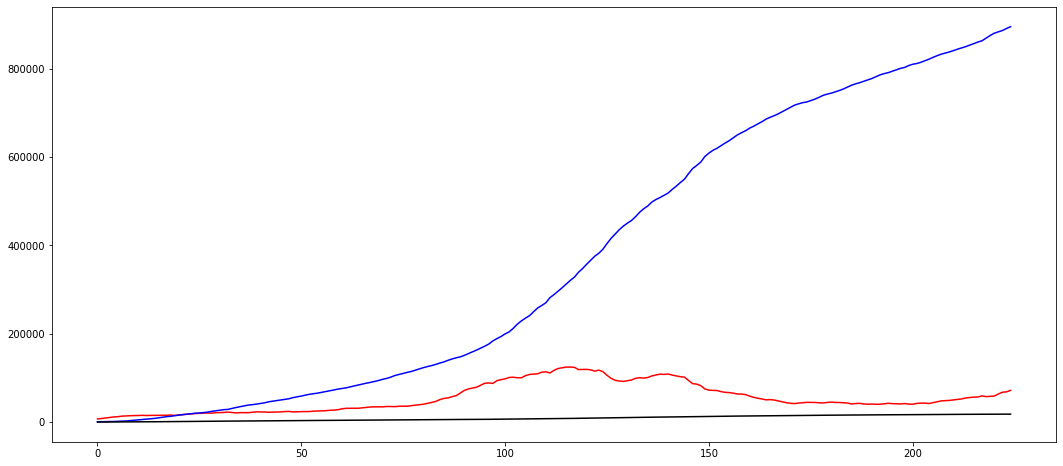

In [24]:
fig,ax = sird_fd.displayData(suscept, infect, recov, dead, graphVals=[0,1,1,1])

In [25]:
b1Range = (0, 5000)
b2Range = (1, 5)

betaVarsResol = [100, 5]

linVars, nonLinVars = sird_fd.solveAllVars(suscept, infect, recov, dead, [b1Range, b2Range], betaVarsResol, printOut=True)

ValueError: could not broadcast input array from shape (203,) into shape (204,)

In [ ]:
sirdLinVars = sird.getLinVars(suscept, infect, recov, dead)

print("cost: ", sird.getError(suscept, infect, recov, dead, sirdLinVars))

In [ ]:
betaTime = sird_fd.getBetaTime(suscept, infect, recov, dead, linVars, nonLinVars)
linVarsTime = sird_time.getLinVars(suscept, infect, recov, dead)
linVarsConst = sird.getLinVars(suscept, infect, recov, dead)


fig, ax = plt.subplots(figsize=(18,8))
ax.plot(np.ones(len(linVarsTime[:,0]))*linVarsConst[0], color="red", linestyle="dotted") #constant beta
ax.plot(betaTime, color="red", linestyle="dashed") #feedback beta
ax.plot(linVarsTime[:,0], color="red") #time varying beta

In [ ]:
dTP= len(suscept) - 10
print(dTP, len(suscept))
print(linVars)

sird_fd.predictMatch(suscept, infect, recov, dead, dTP, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,0,0]);

In [ ]:
#daysToPredict = 180
sird.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);

#note using the nonLinVars is trained on the whole data includinig the predicted days
sird_fd.predictMatch(suscept, infect, recov, dead, daysToPredict, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,0,0]);

#only train nonLinVars on the non predicted days only
sird_fd.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);